# Anomaly Detection

**Author: Daniel Hassler**

In [70]:
from sklearn.datasets import load_iris
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Load Iris Data

For the purpose of anomaly detection and being able to visualize anomalies/outliers, I ran PCA (principal component analysis) to reduce the dimensionality of the iris dataset (without targets) from shape (150, 4) to (150, 2). This allows me to visualize this dataset in two dimensions and makes clustering more efficient and representative of the true data.

In [32]:
iris = load_iris()
pca = PCA(n_components=2)
data_pca = pca.fit_transform(iris.data, iris.target)
df = pd.DataFrame(data_pca, columns=["PC1", "PC2"])
df['target'] = iris.target
print(df)

          PC1       PC2  target
0   -2.684126  0.319397       0
1   -2.714142 -0.177001       0
2   -2.888991 -0.144949       0
3   -2.745343 -0.318299       0
4   -2.728717  0.326755       0
..        ...       ...     ...
145  1.944110  0.187532       2
146  1.527167 -0.375317       2
147  1.764346  0.078859       2
148  1.900942  0.116628       2
149  1.390189 -0.282661       2

[150 rows x 3 columns]


## Plot the Current Iris Data

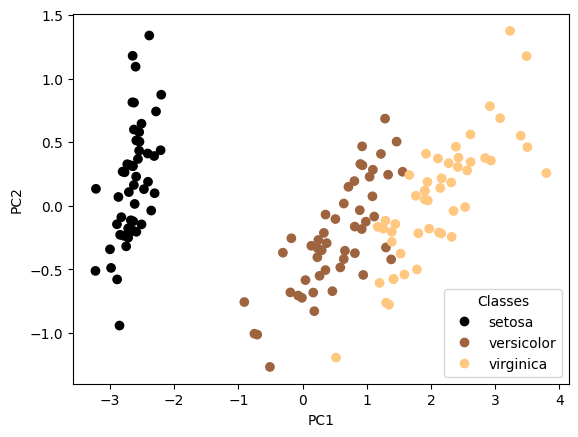

In [57]:
_, ax = plt.subplots()
scatter = ax.scatter(df["PC1"], df["PC2"], c=iris.target, cmap="copper")
ax.set(xlabel="PC1", ylabel="PC2")
_ = ax.legend(
    scatter.legend_elements()[0], iris.target_names, loc="lower right", title="Classes"
)

## Initialize the DBSCAN

In order to create realistic clusters with DBSCAN and maximize an optimization, we need to preform hyperparameter tuning. Below is a GridSearch implementation for tweaking and finding the best `eps` and `min_samples` hyperparameters. 

In [89]:
params = {
    'eps': [i / 10 for i in range(1, 15)],
    'min_samples': [i for i in range(1, 10)]
}

best_score = -1
best_params = {}

for param_i in ParameterGrid(params):
    db = DBSCAN(**param_i)
    labels = db.fit_predict(data_pca)
    # minimum of 4 clusters (3 classes + 1 outlier)
    if len(np.unique(labels)) <= 3:
        continue

    score = silhouette_score(data_pca, labels)
    if score > best_score:
        best_score = score
        best_params = param_i

print("Best Score: ", best_score)
print("Best Params: ", best_params)




Best Score:  0.45189188489361554
Best Params:  {'eps': 0.3, 'min_samples': 6}


In [92]:
db = DBSCAN(**best_params).fit(data_pca)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 3
Estimated number of noise points: 20


## Plot the DBSCAN

Text(0, 0.5, 'PC2')

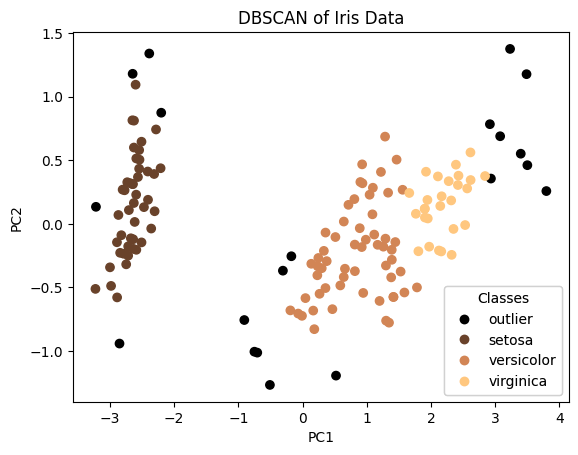

In [91]:
y_pred = db.fit_predict(data_pca)
fig, ax = plt.subplots()
scatter = ax.scatter(df["PC1"], df["PC2"], c=y_pred, cmap='copper')
text_labels = ["outlier", "setosa", "versicolor", "virginica"]
legend1 = ax.legend(scatter.legend_elements()[0], text_labels,
                    loc="lower right", title="Classes")
ax.add_artist(legend1)
plt.title("DBSCAN of Iris Data")
plt.xlabel("PC1")
plt.ylabel("PC2")
